In [114]:
import datetime as dt

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [68]:
import wmfdata as wmf

In [26]:
# Customize Matplotlib styles
%matplotlib inline
mpl.rcParams["font.size"] = 18
mpl.rcParams["figure.figsize"] = (16, 10)

In [93]:
# Ends with most recent data in editor month table
START = "2001-01-01"

# Edits

In [94]:
edits = wmf.mariadb.run(
    """
    select 
    month, 
    sum(edits) as non_bot_edits,
    sum(if(user_name = "", edits, 0)) as anon_edits,
    sum(mobile_web_edits) as mobile_web_edits,
    sum(mobile_app_edits) as mobile_app_edits
    from (
    select month, user_name, sum(edits) as edits,
    sum(mobile_web_edits) as mobile_web_edits,
    sum(mobile_app_edits) as mobile_app_edits,
    max(bot_flag) as bot_flag
    from staging.editor_month
    where month >= "{start}"
    group by month, user_name
    ) global_edits
    where
    bot_flag = 0 and
    convert(user_name using utf8) not regexp "bot\\b" and
    convert(user_name using utf8) not regexp "[ _]bot[ _]"
    group by month;
    """.format(start = START)
)

In [101]:
edits["month"] = pd.to_datetime(edits["month"])
edits = edits.set_index("month")

In [102]:
edits.tail()

,non_bot_edits,anon_edits,mobile_web_edits,mobile_app_edits
month,,,,
2017-12-01,19926661.0,2087239.0,924216.0,96437.0
2018-01-01,20374752.0,2299398.0,1052829.0,98878.0
2018-02-01,19934498.0,2015105.0,931491.0,78616.0
2018-03-01,25176955.0,2219217.0,1026475.0,93662.0
2018-04-01,20762287.0,2091312.0,996572.0,107796.0


# Editors

In [105]:
editors = wmf.mariadb.run(
    """
    select 
    month, 
    count(*) as active_editors,
    sum(extract(year_month from reg) = extract(year_month from month)) as new_active_editors,
    sum(extract(year_month from reg) = extract(year_month from date_sub(month, interval 1 month))) as second_month_active_editors
    from (
    select month, user_name, sum(content_edits) as content_edits, 
    min(user_registration) as reg, max(bot_flag) as bot_flag
    from staging.editor_month
    where local_user_id != 0 and month >= "{start}"
    group by month, user_name
    ) global_edits
    where 
    content_edits >= 5 and bot_flag = 0 and
    convert(user_name using utf8) not regexp "bot\\b" and
    convert(user_name using utf8) not regexp "[ _]bot[ _]"
    group by month;
    """.format(start = START)
)

In [11]:
editors["month"] = pd.to_datetime(editors["month"])

In [15]:
eds = editors.set_index("month")

In [17]:
eds["existing_active_editors"] = eds["active_editors"] - eds["new_active_editors"] - eds["second_month_active_editors"]

In [20]:
eds = eds.drop("active_editors", axis = 1)

In [ ]:
eds = eds[["existing_active_editors", "second_month_active_editors", "new_active_editors"]]

In [53]:
for col in eds.columns:
    eds[col] = eds[col].apply(np.int)

In [64]:
eds.columns = ['existing active editors', 'second month active editors',
       'new (first-month) active editors']

In [67]:
eds.tail()

,existing active editors,second month active editors,new (first-month) active editors
month,,,
2017-12-01,61035,4152,14393
2018-01-01,64412,3354,16679
2018-02-01,59797,4136,15053
2018-03-01,64238,4348,17626
2018-04-01,62923,4739,16060


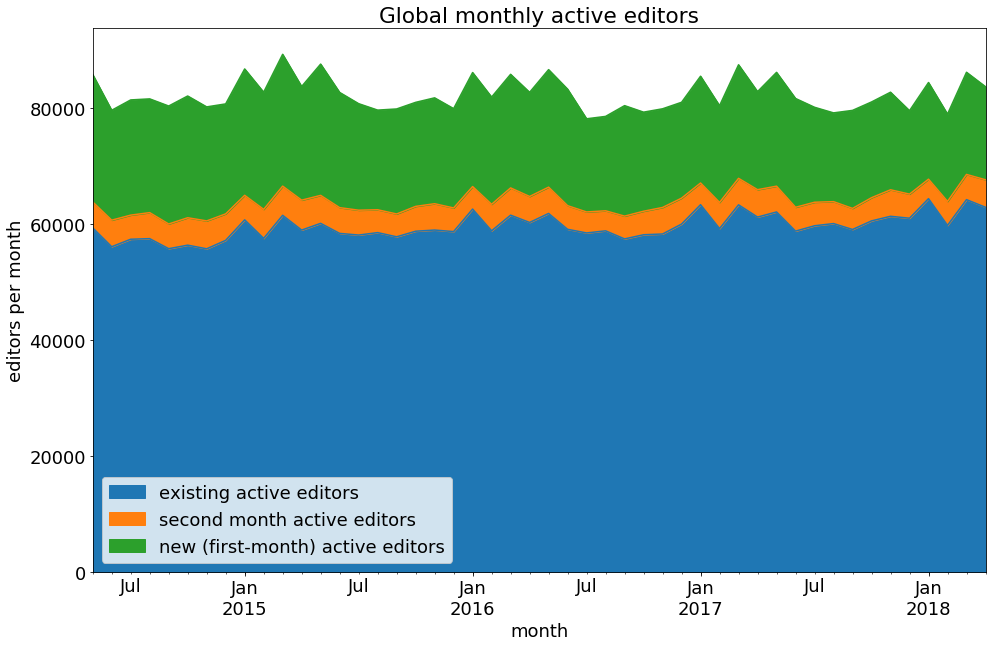

In [66]:
ax = eds.plot.area()
plt.title("Global monthly active editors")
plt.ylabel("editors per month")
plt.autoscale(enable=True, axis="x", tight=True);

## Non-bot edits exploration

In [75]:
edits["month"] = pd.to_datetime(edits["month"])

In [84]:
edits = edits.set_index("month")

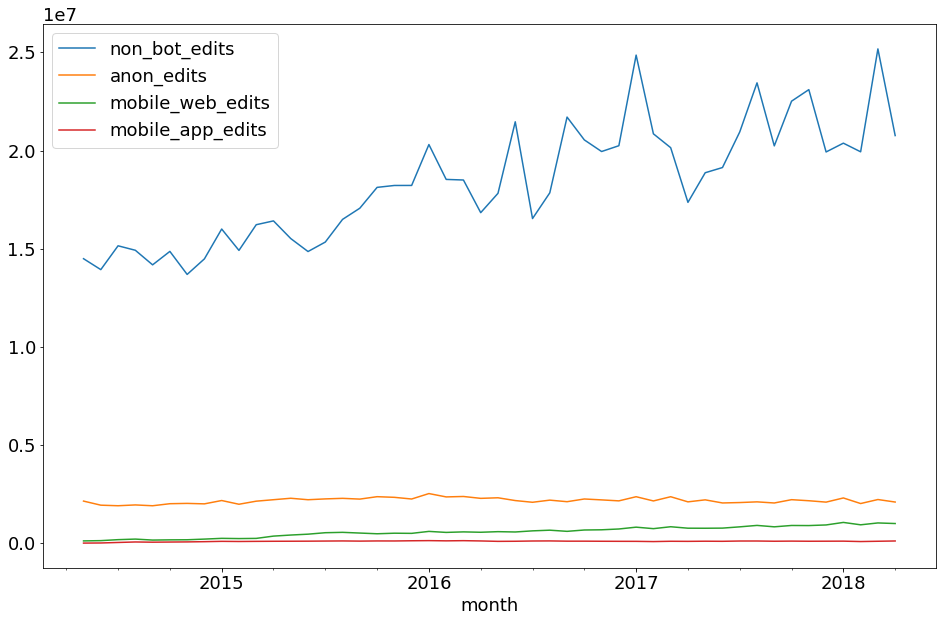

In [85]:
edits.plot()

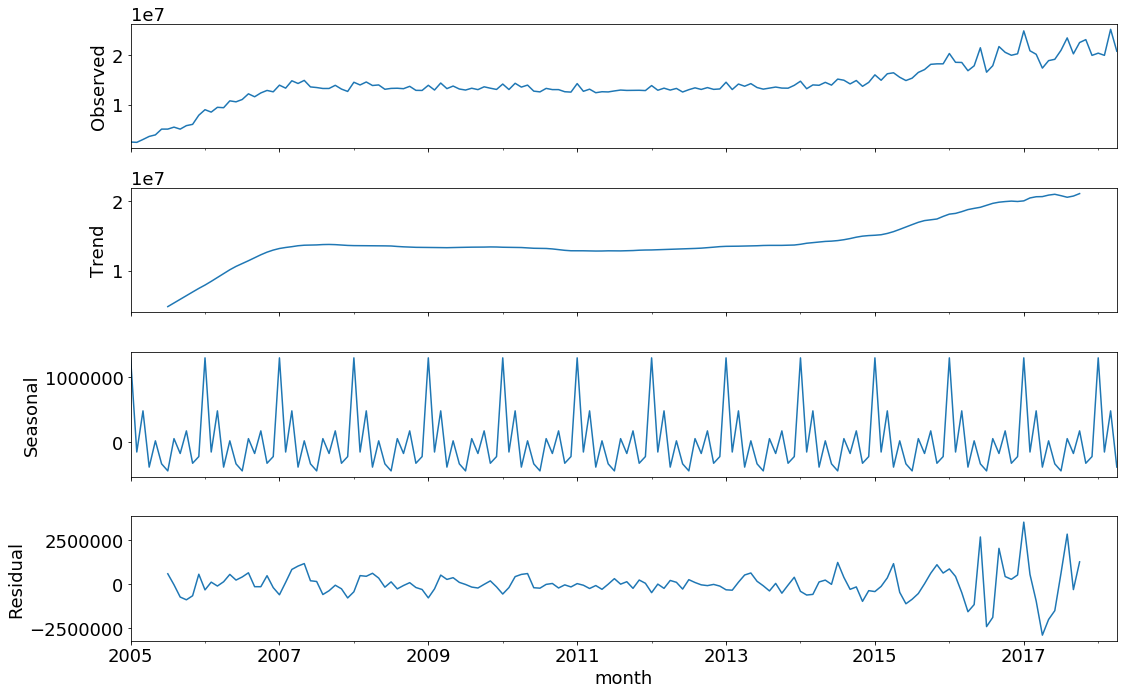

In [115]:
jan_2005 = dt.datetime(2005, 1, 1)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(edits["non_bot_edits"][jan_2005:], model='additive', freq=12)
result.plot()
plt.autoscale(enable=True, axis="x", tight=True)

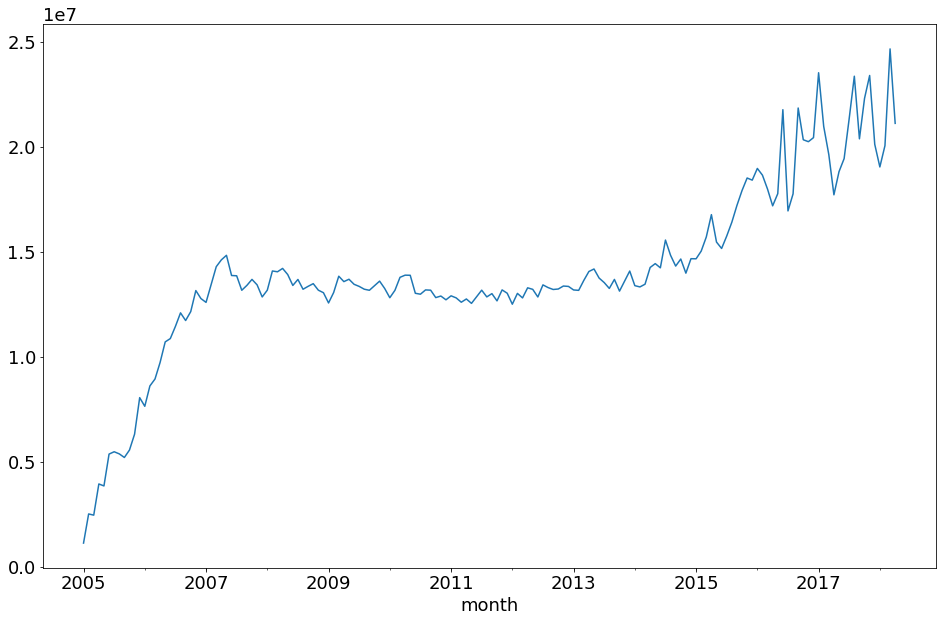

In [116]:
(result.observed - result.seasonal).plot()

In [99]:
from pandas.plotting import autocorrelation_plot

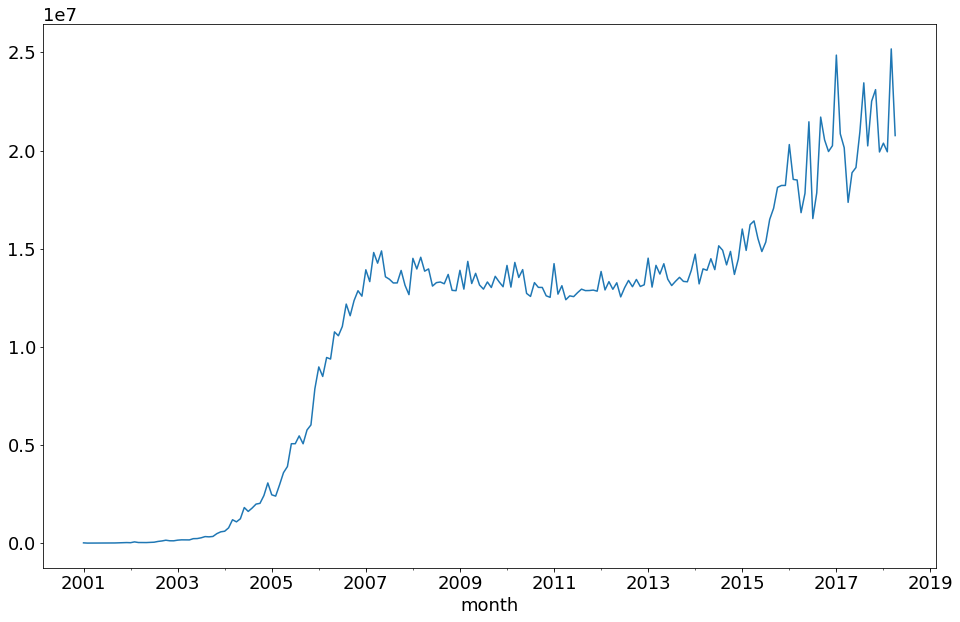

In [109]:
edits["non_bot_edits"].plot()

In [106]:
editor

NameError: name 'editorS' is not defined

In [117]:
d_w_revs = wmf.hive.run("""
    select
        wiki_db as wiki,
        dt as d,
        sum(if(metric = "daily_edits", value, 0)) - sum(if(metric = "daily_edits_by_bot_users", value, 0)) as nonbot_revs
    from wmf.mediawiki_metrics
    where
        snapshot = "2018-04" and
        metric in ("daily_edits", "daily_edits_by_bot_users")
    group by wiki_db, dt
""")

In [120]:
d_w_revs["d"] = pd.to_datetime(d_w_revs["d"])
d_w_revs = d_w_revs.set_index("d")

In [253]:
d_revs = pd.DataFrame({"tot": tot["2016":], "non_wd": non_wd["2016":], "wd": wd["2016":]})
d_revs.head()

,non_wd,tot,wd
d,,,
2016-01-01,469730.600000,602975.033333,133244.433333
2016-01-02,471525.166667,607821.766667,136296.600000
2016-01-03,473828.733333,612518.233333,138689.500000
2016-01-04,477054.500000,613484.466667,136429.966667
2016-01-05,478860.033333,613469.566667,134609.533333


In [254]:
d_revs.tail()

,non_wd,tot,wd
d,,,
2018-03-27,545907.966667,862677.400000,316769.433333
2018-03-28,545753.233333,852034.033333,306280.800000
2018-03-29,545382.133333,838622.566667,293240.433333
2018-03-30,543622.066667,827337.133333,283715.066667
2018-03-31,544325.566667,818882.866667,274557.300000


In [255]:
d_norm = d_revs.apply(lambda x: ((x - x[0])) / x[0])
d_norm.tail()

,non_wd,tot,wd
d,,,
2018-03-27,0.162172,0.430702,1.377356
2018-03-28,0.161843,0.413050,1.298639
2018-03-29,0.161053,0.390808,1.200771
2018-03-30,0.157306,0.372092,1.129283
2018-03-31,0.158804,0.358071,1.060554


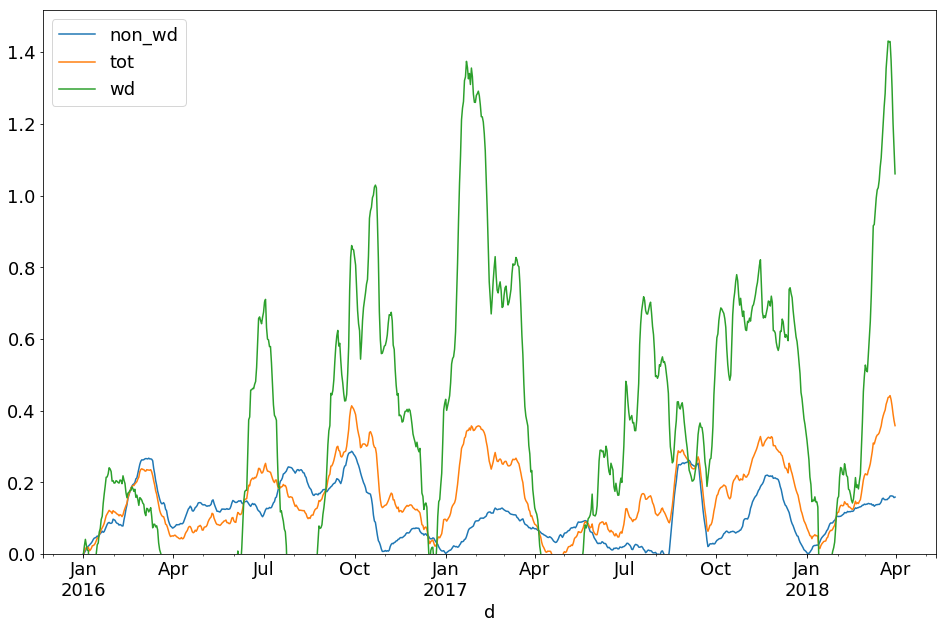

In [256]:
d_norm.plot(ylim=0);

In [141]:
tot = d_w_revs.groupby("d")["nonbot_revs"].sum().rolling(30).mean()

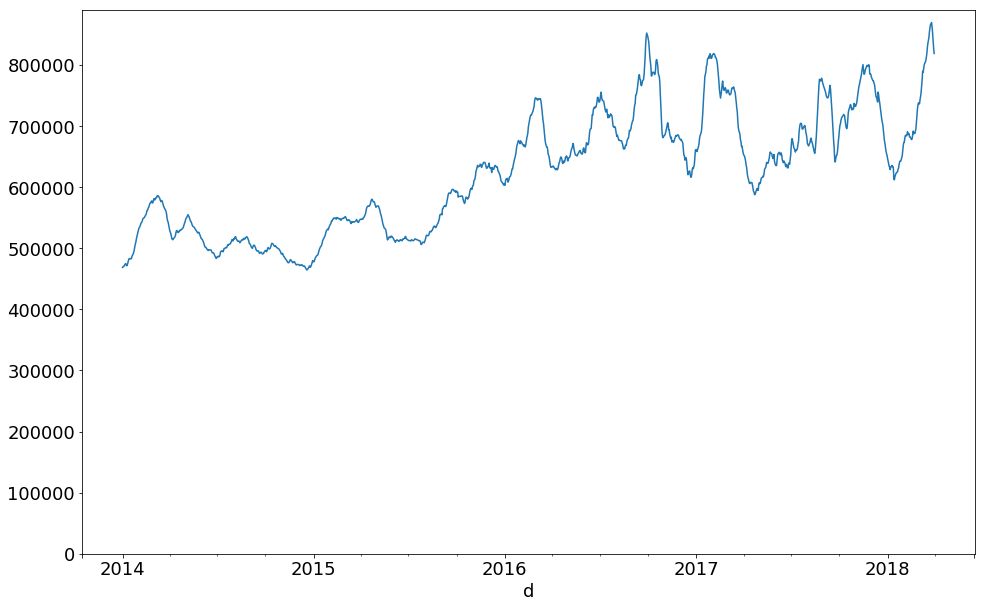

In [184]:
tot["2014":].plot(ylim=0)

In [130]:
non_wd = d_w_revs.query("wiki != 'wikidatawiki'").groupby("d")["nonbot_revs"].sum().rolling(30).mean()

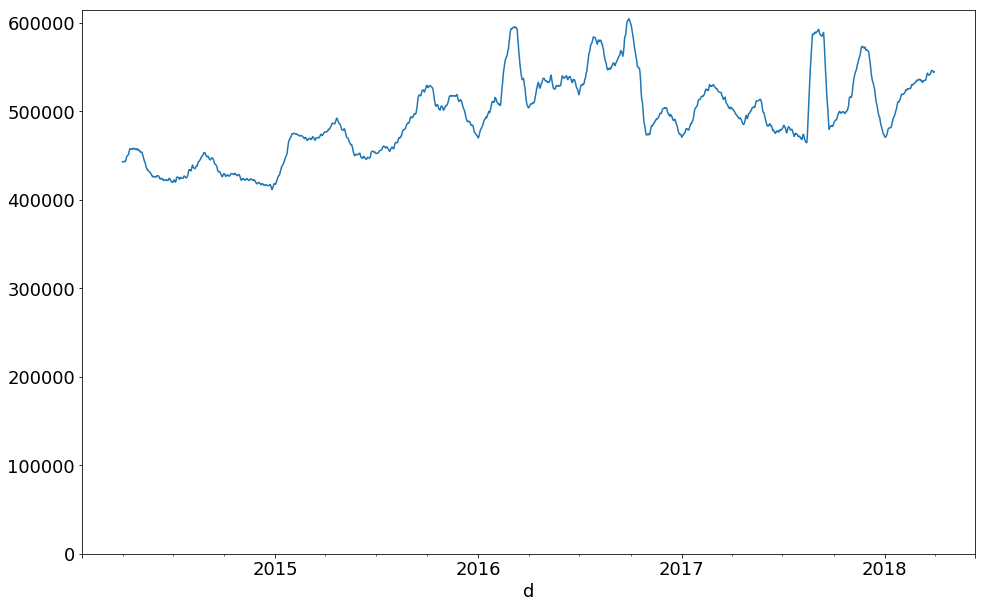

In [157]:
non_wd["2014-04":].plot(ylim=0)

In [206]:
wd = d_w_revs.query("wiki == 'wikidatawiki'").groupby("d")["nonbot_revs"].sum().rolling(30).mean()

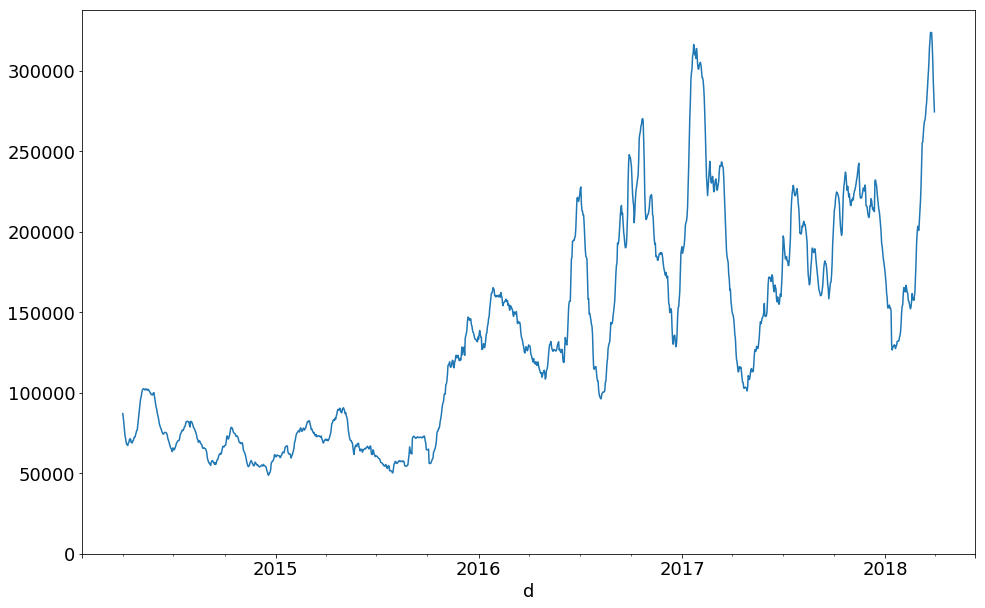

In [224]:
wd["2014-04":].plot(ylim=0);